In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score,roc_curve
import matplotlib.pyplot as plt
import joblib

In [2]:
train_data = pd.read_csv("../../data/model_train_data.csv")
test_data = pd.read_csv("../../data/model_test_data.csv")

In [3]:
train_data.describe()

,age,income_level,fico_score,delinquency_status,charge_off_status,number_of_credit_applications,debt_to_income_ratio,payment_methods_high_risk,max_balance,avg_balance_last_12months,...,number_of_defaulted_accounts,new_accounts_opened_last_12months,multiple_applications_short_time_period,unusual_submission_pattern,applications_submitted_during_odd_hours,watchlist_blacklist_flag,public_records_flag,account_age_days,earliest_credit_account_age_days,days_recent_trade_activity
count,5398.000000,5398.000000,5398.000000,5398.000000,5398.000000,5398.000000,5398.000000,5398.000000,5398.000000,5398.000000,...,5398.000000,5398.000000,5398.00000,5398.000000,5398.000000,5398.000000,5398.000000,5398.000000,5398.000000,5398.000000
mean,46.224528,23527.375324,615.116895,25.474991,0.263616,1.838273,1.474413,0.238977,50094.307788,33267.860916,...,0.506113,1.390515,0.25917,0.207670,0.312338,0.123935,0.201000,962.302149,1855.394591,223.654687
std,16.412856,21878.658332,130.005913,42.910907,0.440634,1.984086,0.669770,0.426498,49722.417608,21750.712757,...,0.733954,1.596085,0.43822,0.405676,0.463490,0.329538,0.400785,524.591119,1048.202676,106.060833
min,18.000000,2003.000000,301.000000,0.000000,0.000000,1.000000,0.448678,0.000000,930.516529,467.221957,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,42.000000,42.000000,42.000000
25%,32.000000,6859.750000,520.000000,0.000000,0.000000,1.000000,1.052770,0.000000,25272.676740,14179.244192,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,512.000000,956.250000,131.000000
50%,46.000000,14880.500000,633.000000,0.000000,0.000000,1.000000,1.318397,0.000000,44512.391347,30352.353060,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,968.000000,1840.000000,224.000000
75%,61.000000,37427.500000,721.000000,31.000000,1.000000,1.000000,1.715266,0.000000,69667.032476,50608.640512,...,1.000000,3.000000,1.00000,0.000000,1.000000,0.000000,0.000000,1415.000000,2772.000000,314.000000
max,74.000000,99957.000000,848.000000,119.000000,1.000000,10.000000,9.927906,1.000000,999922.083300,92117.793445,...,2.000000,4.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1868.000000,3694.000000,407.000000


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5398 entries, 0 to 5397
Data columns (total 23 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   age                                      5398 non-null   int64  
 1   location                                 5398 non-null   object 
 2   occupation                               5398 non-null   object 
 3   income_level                             5398 non-null   int64  
 4   fico_score                               5398 non-null   float64
 5   delinquency_status                       5398 non-null   int64  
 6   charge_off_status                        5398 non-null   int64  
 7   number_of_credit_applications            5398 non-null   int64  
 8   debt_to_income_ratio                     5398 non-null   float64
 9   payment_methods_high_risk                5398 non-null   int64  
 10  max_balance                              5398 no

## Seperate Features and Target

In [5]:
target = 'charge_off_status'

X_train = train_data.drop(columns=[target])  
y_train = train_data[target]  

X_test = test_data.drop(columns=[target])  
y_test = test_data[target]  

In [6]:
# numerical_features = ["age",
#                       "fico_score",
#                       "income_level",
#                       "delinquency_status",
#                       "max_balance",
#                       "avg_balance_last_12months",
#                       "account_age_days",
#                      "earliest_credit_account_age_days",
#                       "days_recent_trade_activity",
#                       "new_accounts_opened_last_12months",
#                      "number_of_delinquent_accounts",
#                       "number_of_defaulted_accounts",
#                       "number_of_credit_applications",
#                       "debt_to_income_ratio"]

# scaler = MinMaxScaler()

# train_data[numerical_features] = scaler.fit_transform(train_data[numerical_features])
# test_data[numerical_features] = scaler.transform(test_data[numerical_features])

## One-hot encoding categorical features

In [7]:
categorical_features = ["occupation", "location"]

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_encoded = encoder.fit_transform(X_train[categorical_features])
X_test_encoded = encoder.transform(X_test[categorical_features])

encoded_columns = encoder.get_feature_names_out(categorical_features)
X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoded_columns)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=encoded_columns)

X_train = X_train.drop(columns=categorical_features).reset_index(drop=True)
X_test = X_test.drop(columns=categorical_features).reset_index(drop=True)

X_train = pd.concat([X_train, X_train_encoded], axis=1)
X_test = pd.concat([X_test, X_test_encoded], axis=1)

In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5398 entries, 0 to 5397
Data columns (total 41 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   age                                      5398 non-null   int64  
 1   income_level                             5398 non-null   int64  
 2   fico_score                               5398 non-null   float64
 3   delinquency_status                       5398 non-null   int64  
 4   number_of_credit_applications            5398 non-null   int64  
 5   debt_to_income_ratio                     5398 non-null   float64
 6   payment_methods_high_risk                5398 non-null   int64  
 7   max_balance                              5398 non-null   float64
 8   avg_balance_last_12months                5398 non-null   float64
 9   number_of_delinquent_accounts            5398 non-null   float64
 10  number_of_defaulted_accounts             5398 no

## Training XGBoost Model (Basic)

In [9]:
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',  
    eval_metric='logloss',    
    random_state=1  
)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=1, ...)

In [10]:
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1] 

In [11]:
# Accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC Score
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob)}")


Accuracy: 0.8540740740740741
Confusion Matrix:
[[953  61]
 [136 200]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1014
           1       0.77      0.60      0.67       336

    accuracy                           0.85      1350
   macro avg       0.82      0.77      0.79      1350
weighted avg       0.85      0.85      0.85      1350

ROC-AUC Score: 0.8041731238846623


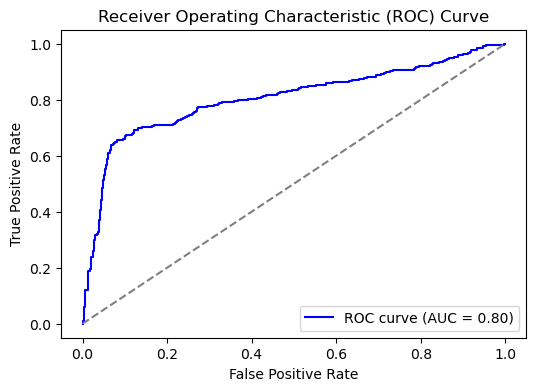

In [12]:
# Get ROC curve data
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc_score(y_test, y_prob):.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

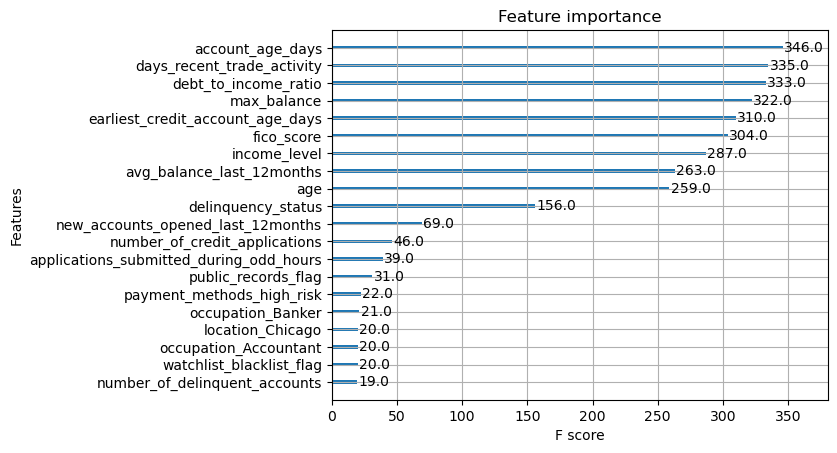

In [13]:
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=20)
plt.show()


In [14]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb.XGBClassifier(use_label_encoder=False), param_grid=param_grid, cv=3, n_jobs=-1, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best ROC-AUC Score:", grid_search.best_score_)


Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Best ROC-AUC Score: 0.8260560369956019


C:\Users\hcham\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:10:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## Training XGBoost Model (Hyper Parameter Tuned Model)

In [15]:
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
xgb_model_2 = xgb.XGBClassifier(
    objective='binary:logistic',  
    eval_metric='logloss', 
    scale_pos_weight=scale_pos_weight,
    random_state=1,
    n_estimators= 100,
    max_depth= 3,
    learning_rate= 0.05,
    subsample= 0.5, reg_lambda= 1, reg_alpha= 1, colsample_bytree= 0.7,min_child_weight= 1
    
)
xgb_model_2.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=1, ...)

In [16]:
y_pred = xgb_model_2.predict(X_test)
y_prob = xgb_model_2.predict_proba(X_test)[:, 1] 

In [20]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Classification Report:")
print(classification_report(y_test, y_pred))

print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob)}")


Accuracy: 0.8674074074074074
Confusion Matrix:
[[943  71]
 [108 228]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91      1014
           1       0.76      0.68      0.72       336

    accuracy                           0.87      1350
   macro avg       0.83      0.80      0.82      1350
weighted avg       0.86      0.87      0.86      1350

ROC-AUC Score: 0.8261423405654175


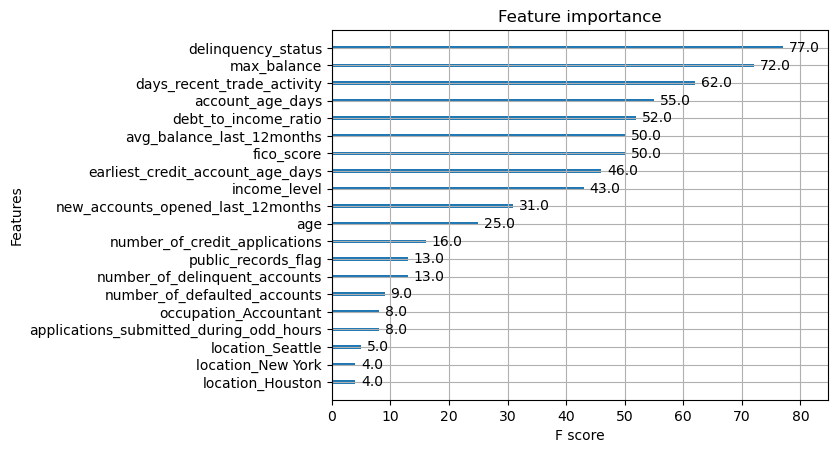

In [18]:
xgb.plot_importance(xgb_model_2, importance_type='weight', max_num_features=20)
plt.show()

In [19]:
joblib.dump(xgb_model_2, '../../models/competition_version(initial)/xgboost_model.pkl')

['../models/xgboost_model.pkl']